In [1]:
from tqdm import tqdm
import requests
import pandas as pd
import numpy as np

from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPool1D

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import imblearn

/home/milosevicn/.local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
2022-10-18 12:35:09.684987: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
assays = [
    "ATG_PPARg_TRANS_dn", 
    "ATG_PPARg_TRANS_up", 
    "TOX21_PPARg_BLA_antagonist_ratio", 
    "TOX21_PPARg_BLA_Agonist_ratio", 
    "NVS_NR_hPPARg", 
    "ERF_ENZ_hCYP19A1_dn", 
    "NVS_ADME_hCYP19A1", 
    "NVS_ADME_hCYP19A1_Activator", 
    "TOX21_Aromatase_Inhibition", 
    "CEETOX_H295R_ESTRADIOL_dn", 
    "CEETOX_H295R_ESTRADIOL_noMTC_dn", 
    "CEETOX_H295R_ESTRADIOL_noMTC_up", 
    "CEETOX_H295R_ESTRADIOL_up", 
    "CEETOX_H295R_ESTRONE_dn", 
    "CEETOX_H295R_ESTRONE_noMTC_dn", 
    "CEETOX_H295R_ESTRONE_noMTC_up", 
    "CEETOX_H295R_ESTRONE_up"
]

In [3]:
# find all matching

dfs = []
smiles = []

for assay in assays:
    path = f"data/{assay}.csv"
    df = pd.read_csv(path)
    # print(df["smiles"].isnull().sum())
    
    s = df[["preferredName", "smiles"]].copy()
    s.index = s["preferredName"]
    del s["preferredName"]
    smiles.append(s)
    
    df = df[["preferredName", "hitc"]] # only leave these two columns
    
    df = df[df["hitc"] != -1] # 22.9.2022.: remove inconclusive results
    
    df.index = df["preferredName"] 
    del df["preferredName"] # set index to name and remove the column name
    df.columns = [assay] # set type (only remaining column) to name of assay
    # df.dropna(inplace=True)  # TODO: search for names in some other way?
    
    dfs.append(df)

# save for later
smiles = pd.concat(smiles, axis=0)
smiles = smiles[~smiles.index.duplicated(keep='first')]

In [4]:
smiles.isnull().sum() # should be zero, run fix-smiles!

smiles    0
dtype: int64

# Single Key Event Convs (SKEC)

RDKit ERROR: [12:35:21] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
[12:35:21] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
RDKit ERROR: [12:35:21] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
[12:35:21] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
RDKit ERROR: [12:35:21] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[12:35:21] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-

Bad smiles string for Calcium dodecylbenzene sulfonate
Bad smiles string for Dinocap


[12:35:21] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
RDKit ERROR: [12:35:22] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
[12:35:22] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
RDKit ERROR: [12:35:22] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
[12:35:22] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'


Bad smiles string for 4-Nonylphenol, branched
Bad smiles string for Zinc pyrithione
Bad smiles string for Diisooctyl adipate


RDKit ERROR: [12:35:22] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:35:22] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:35:22] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [12:35:22] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[12:35:22] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[12:35:22] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
RDKit ERROR: [12:35:22] Explicit valence for atom # 4 C, 5, is greater than permitted
[12:35:22] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [12:35:22] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:35:22] SMILES Parse Error: syntax error while p

Bad smiles string for (Methylcyclopentadienyl)tricarbonylmanganese
Bad smiles string for Benzalkonium chloride
Bad smiles string for Sodium hexafluorosilicate
Bad smiles string for Calcium dodecylbenzene sulfonate


RDKit ERROR: [12:35:22] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:35:22] Explicit valence for atom # 3 Si, 8, is greater than permitted
RDKit ERROR: [12:35:22] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
[12:35:22] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
RDKit ERROR: [12:35:22] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
[12:35:22] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
RDKit ERROR: [12:35:22] SMILES Parse Error: syntax error whil

Bad smiles string for Dinocap
Bad smiles string for 4-Nonylphenol, branched


RDKit ERROR: [12:35:23] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:35:23] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:35:23] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [12:35:23] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[12:35:23] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[12:35:23] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'


Bad smiles string for Zinc pyrithione
Bad smiles string for Diisooctyl adipate


RDKit ERROR: [12:35:23] Explicit valence for atom # 4 C, 5, is greater than permitted
[12:35:23] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [12:35:23] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:35:23] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
RDKit ERROR: [12:35:23] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:35:23] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:35:23] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:35:23] Explicit valence for atom # 3 Si, 8, is greater than permitted
RDKit ERROR: [12:35:23] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
[12:35:23] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
RDKit ERROR: [12:35:23] S

Bad smiles string for (Methylcyclopentadienyl)tricarbonylmanganese
Bad smiles string for Benzalkonium chloride
Bad smiles string for Sodium hexafluorosilicate
Bad smiles string for Diisopropylbenzene


RDKit ERROR: [12:35:23] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
[12:35:23] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
RDKit ERROR: [12:35:23] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
[12:35:23] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'


Bad smiles string for Calcium dodecylbenzene sulfonate


RDKit ERROR: [12:35:24] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[12:35:24] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
RDKit ERROR: [12:35:24] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
[12:35:24] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
RDKit ERROR: [12:35:24] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:35:24] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [12:35:24] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:35:24] Explicit valence for atom # 0 N, 4, is greater than permitted


Bad smiles string for Dinocap
Bad smiles string for Carboplatin
Bad smiles string for Cisplatin


RDKit ERROR: [12:35:24] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
[12:35:24] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
RDKit ERROR: [12:35:24] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
[12:35:24] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'


Bad smiles string for 4-Nonylphenol, branched


RDKit ERROR: [12:35:24] Explicit valence for atom # 7 Mg, 6, is greater than permitted
[12:35:24] Explicit valence for atom # 7 Mg, 6, is greater than permitted
RDKit ERROR: [12:35:25] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:35:25] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:35:25] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [12:35:25] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[12:35:25] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[12:35:25] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
RDKit ERROR: [12:35:25] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:35:25] Explicit valence for atom # 1 C, 5, is greater than permi

Bad smiles string for Magnesium, bis(salicylato)-, tetrahydrate
Bad smiles string for Zinc pyrithione
Bad smiles string for Diisooctyl adipate
Bad smiles string for Vitamin B12


RDKit WARNING: [12:35:25] WARNING: not removing hydrogen atom without neighbors
[12:35:25] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:35:25] Explicit valence for atom # 0 F, 2, is greater than permitted
[12:35:25] Explicit valence for atom # 0 F, 2, is greater than permitted
RDKit ERROR: [12:35:25] Explicit valence for atom # 4 C, 5, is greater than permitted
[12:35:25] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [12:35:25] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
RDKit ERROR: [12:35:25] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']' for input: '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']'


Bad smiles string for 1-Ethyl-1-methylpyrrolidinium tetrafluoroborate
Bad smiles string for (Methylcyclopentadienyl)tricarbonylmanganese
Bad smiles string for 1,2-Benzenedicarboxylic acid, di-C6-8-branched alkyl esters, C7-rich
Bad smiles string for Benzalkonium chloride
Bad smiles string for Sodium hexafluorosilicate


RDKit ERROR: [12:35:25] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:35:25] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:35:25] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
[12:35:25] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']' for input: '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']'
[12:35:25] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:35:25] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:35:25] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:35:25] Explicit valence for atom # 3 Si, 8, is greater than permitted
RDKit ERROR: [12:35:25] SMILES Pa

Bad smiles string for Diisopropylbenzene
Bad smiles string for Gentamicin sulfate


[12:35:25] SMILES Parse Error: syntax error while parsing: ['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1
[12:35:25] SMILES Parse Error: Failed parsing SMILES '['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1' for input: '['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1'
RDKit ERROR: [12:35:25] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
[12:35:25] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
RDKit ERROR: [12:35:25] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
[12:35:25] SMILES Parse Error: Failed par

Bad smiles string for Calcium dodecylbenzene sulfonate


RDKit ERROR: [12:35:26] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[12:35:26] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
RDKit ERROR: [12:35:26] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
[12:35:26] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
RDKit ERROR: [12:35:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:35:26] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [12:35:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:35:26] Explicit valence for atom # 0 N, 4, is greater than permitted


Bad smiles string for Dinocap
Bad smiles string for Carboplatin
Bad smiles string for Cisplatin


RDKit ERROR: [12:35:26] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
[12:35:26] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
RDKit ERROR: [12:35:26] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
RDKit ERROR: [12:35:26] SMILES Parse Error: syntax error while parsing: ['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O
RDKit ERROR: [12:35:26] SMILES Parse Error: Failed parsing SMILES '['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O' for input: '['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O'
[12:35:26] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
[12:35:26] SMILES Parse Error: syntax error while parsing: ['Rgp'][C@@H]1N2C(=

Bad smiles string for 4-Nonylphenol, branched
Bad smiles string for Hydergine
Bad smiles string for Aurothioglucose


RDKit ERROR: [12:35:27] Explicit valence for atom # 7 Mg, 6, is greater than permitted
[12:35:27] Explicit valence for atom # 7 Mg, 6, is greater than permitted
RDKit ERROR: [12:35:27] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:35:27] Explicit valence for atom # 3 Si, 8, is greater than permitted
RDKit ERROR: [12:35:27] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:35:27] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:35:27] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [12:35:27] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[12:35:27] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[12:35:27] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCC

Bad smiles string for Magnesium, bis(salicylato)-, tetrahydrate
Bad smiles string for Ammonium hexafluorosilicate
Bad smiles string for Zinc pyrithione
Bad smiles string for Diisooctyl adipate
Bad smiles string for Vitamin B12


RDKit WARNING: [12:35:27] WARNING: not removing hydrogen atom without neighbors
[12:35:27] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:35:27] Explicit valence for atom # 0 F, 2, is greater than permitted
[12:35:27] Explicit valence for atom # 0 F, 2, is greater than permitted


Bad smiles string for 1-Ethyl-1-methylpyrrolidinium tetrafluoroborate
Bad smiles string for (Methylcyclopentadienyl)tricarbonylmanganese
Bad smiles string for 1,2-Benzenedicarboxylic acid, di-C6-8-branched alkyl esters, C7-rich
Bad smiles string for Benzalkonium chloride
Bad smiles string for Sodium hexafluorosilicate


RDKit ERROR: [12:35:27] Explicit valence for atom # 4 C, 5, is greater than permitted
[12:35:27] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [12:35:27] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
[12:35:27] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
RDKit ERROR: [12:35:27] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']' for input: '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']'
[12:35:27] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']' for input: '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']'
RDKit ERROR: [12:35:27] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:35:27] SMILES Parse Error: Failed par

Bad smiles string for Calcium dodecylbenzene sulfonate
Bad smiles string for Dinocap
Bad smiles string for 4-Nonylphenol, branched
Bad smiles string for Diisooctyl adipate
Bad smiles string for Benzalkonium chloride
ok: 23426
bad: ['Calcium dodecylbenzene sulfonate', 'Dinocap', '4-Nonylphenol, branched', 'Zinc pyrithione', 'Diisooctyl adipate', '(Methylcyclopentadienyl)tricarbonylmanganese', 'Benzalkonium chloride', 'Sodium hexafluorosilicate', 'Calcium dodecylbenzene sulfonate', 'Dinocap', '4-Nonylphenol, branched', 'Zinc pyrithione', 'Diisooctyl adipate', '(Methylcyclopentadienyl)tricarbonylmanganese', 'Benzalkonium chloride', 'Sodium hexafluorosilicate', 'Diisopropylbenzene', 'Calcium dodecylbenzene sulfonate', 'Dinocap', 'Carboplatin', 'Cisplatin', '4-Nonylphenol, branched', 'Magnesium, bis(salicylato)-, tetrahydrate', 'Zinc pyrithione', 'Diisooctyl adipate', 'Vitamin B12', '1-Ethyl-1-methylpyrrolidinium tetrafluoroborate', '(Methylcyclopentadienyl)tricarbonylmanganese', '1,2-Benze

RDKit ERROR: [12:35:27] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[12:35:27] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
RDKit ERROR: [12:35:27] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
[12:35:27] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
RDKit ERROR: [12:35:27] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
[12:35:27] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
RDKit ERROR: [12:35:27] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
[12:35:27] SMILES Parse Error: Failed parsing SMILES '

Epoch 1/25


2022-10-18 12:35:31.414397: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-18 12:35:31.564670: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1053/1053 [==============================] - 17s 15ms/step - loss: 0.9413 - accuracy: 0.5105 - val_loss: 0.7122 - val_accuracy: 0.5659
Epoch 2/25
1053/1053 [==============================] - 15s 14ms/step - loss: 0.8472 - accuracy: 0.6145 - val_loss: 0.8227 - val_accuracy: 0.5593
Epoch 3/25
1053/1053 [==============================] - 15s 14ms/step - loss: 0.7297 - accuracy: 0.7162 - val_loss: 0.4184 - val_accuracy: 0.8239
Epoch 4/25
1053/1053 [==============================] - 15s 14ms/step - loss: 0.5963 - accuracy: 0.7894 - val_loss: 0.3469 - val_accuracy: 0.8551
Epoch 5/25
1053/1053 [==============================] - 15s 14ms/step - loss: 0.4699 - accuracy: 0.8418 - val_loss: 1.2045 - val_accuracy: 0.5808
Epoch 6/25
1053/1053 [==============================] - 15s 14ms/step - loss: 0.4099 - accuracy: 0.8634 - val_loss: 0.3859 - val_accuracy: 0.8367
Epoch 7/25
1053/1053 [==============================] - 15s 14ms/step - loss: 0.3623 - accuracy: 0.8809 - val_loss: 0.3130 - val_accura

2022-10-18 12:41:43.594492: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 500170752 exceeds 10% of free system memory.


model saved ke1


RDKit ERROR: [12:41:45] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
[12:41:45] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
RDKit ERROR: [12:41:45] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.CC(C)c1ccccc1' for input: '[X]C(C)C.CC(C)c1ccccc1'
[12:41:45] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.CC(C)c1ccccc1' for input: '[X]C(C)C.CC(C)c1ccccc1'
RDKit ERROR: [12:41:45] SMILES Parse Error: syntax error while parsing: ['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1
[12:41:45] SMILES Parse Error: syntax error while parsing: ['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1
RDKit ERROR: [12:41:45] SMILES Parse Error: Failed parsing SMILES '['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1' for input: '['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(N

Bad smiles string for Diisopropylbenzene
Bad smiles string for Gentamicin sulfate


RDKit ERROR: [12:41:45] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
[12:41:45] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
RDKit ERROR: [12:41:45] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
[12:41:45] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'


Bad smiles string for Calcium dodecylbenzene sulfonate


RDKit ERROR: [12:41:45] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[12:41:45] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
RDKit ERROR: [12:41:45] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
[12:41:45] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
RDKit ERROR: [12:41:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:41:45] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [12:41:46] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:41:46] Explicit valence for atom # 0 N, 4, is greater than permitted


Bad smiles string for Dinocap
Bad smiles string for Carboplatin
Bad smiles string for Cisplatin


RDKit ERROR: [12:41:46] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
[12:41:46] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
RDKit ERROR: [12:41:46] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
RDKit ERROR: [12:41:46] SMILES Parse Error: syntax error while parsing: ['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O
RDKit ERROR: [12:41:46] SMILES Parse Error: Failed parsing SMILES '['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O' for input: '['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O'
[12:41:46] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
[12:41:46] SMILES Parse Error: syntax error while parsing: ['Rgp'][C@@H]1N2C(=

Bad smiles string for 4-Nonylphenol, branched
Bad smiles string for Hydergine
Bad smiles string for Aurothioglucose


RDKit ERROR: [12:41:46] Explicit valence for atom # 7 Mg, 6, is greater than permitted
[12:41:46] Explicit valence for atom # 7 Mg, 6, is greater than permitted
RDKit ERROR: [12:41:46] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:41:46] Explicit valence for atom # 3 Si, 8, is greater than permitted
RDKit ERROR: [12:41:46] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:41:46] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:41:46] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[12:41:46] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [12:41:46] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[12:41:46] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCC

Bad smiles string for Magnesium, bis(salicylato)-, tetrahydrate
Bad smiles string for Ammonium hexafluorosilicate
Bad smiles string for Zinc pyrithione
Bad smiles string for Diisooctyl adipate
Bad smiles string for Vitamin B12


RDKit WARNING: [12:41:47] WARNING: not removing hydrogen atom without neighbors
[12:41:47] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:41:47] Explicit valence for atom # 0 F, 2, is greater than permitted
[12:41:47] Explicit valence for atom # 0 F, 2, is greater than permitted


Bad smiles string for 1-Ethyl-1-methylpyrrolidinium tetrafluoroborate
Bad smiles string for (Methylcyclopentadienyl)tricarbonylmanganese
Bad smiles string for 1,2-Benzenedicarboxylic acid, di-C6-8-branched alkyl esters, C7-rich
Bad smiles string for Benzalkonium chloride
Bad smiles string for Sodium hexafluorosilicate


RDKit ERROR: [12:41:47] Explicit valence for atom # 4 C, 5, is greater than permitted
[12:41:47] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [12:41:47] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
RDKit ERROR: [12:41:47] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']' for input: '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']'
[12:41:47] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
RDKit ERROR: [12:41:47] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:41:47] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:41:47] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OC

ok: 8592
bad: ['Diisopropylbenzene', 'Gentamicin sulfate', 'Calcium dodecylbenzene sulfonate', 'Dinocap', 'Carboplatin', 'Cisplatin', '4-Nonylphenol, branched', 'Hydergine', 'Aurothioglucose', 'Magnesium, bis(salicylato)-, tetrahydrate', 'Ammonium hexafluorosilicate', 'Zinc pyrithione', 'Diisooctyl adipate', 'Vitamin B12', '1-Ethyl-1-methylpyrrolidinium tetrafluoroborate', '(Methylcyclopentadienyl)tricarbonylmanganese', '1,2-Benzenedicarboxylic acid, di-C6-8-branched alkyl esters, C7-rich', 'Benzalkonium chloride', 'Sodium hexafluorosilicate']
bad count: 19
Epoch 1/25
365/365 [==============================] - 6s 15ms/step - loss: 0.9649 - accuracy: 0.5047 - val_loss: 0.7562 - val_accuracy: 0.4837
Epoch 2/25
365/365 [==============================] - 5s 14ms/step - loss: 0.9086 - accuracy: 0.5126 - val_loss: 0.6354 - val_accuracy: 0.6421
Epoch 3/25
365/365 [==============================] - 5s 14ms/step - loss: 0.8352 - accuracy: 0.6130 - val_loss: 0.5977 - val_accuracy: 0.6846
Epoch 4

2022-10-18 12:43:57.426454: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 500170752 exceeds 10% of free system memory.


model saved ke2
Bad smiles string for Benzalkonium chloride


RDKit ERROR: [12:43:58] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:43:58] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:43:58] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:43:58] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
RDKit ERROR: [12:43:58] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:43:58] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:43:58] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:43:58] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
RDKit ERROR: [12:43:59] SMILES Parse Error: 

Bad smiles string for Benzalkonium chloride
Bad smiles string for Benzalkonium chloride


RDKit ERROR: [12:43:59] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:43:59] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:43:59] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:43:59] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
/home/milosevicn/miniconda3/envs/bio/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Bad smiles string for Benzalkonium chloride
ok: 2620
bad: ['Benzalkonium chloride', 'Benzalkonium chloride', 'Benzalkonium chloride', 'Benzalkonium chloride']
bad count: 4
Epoch 1/25
119/119 [==============================] - 2s 16ms/step - loss: 0.9900 - accuracy: 0.5072 - val_loss: 0.7317 - val_accuracy: 0.4947
Epoch 2/25
119/119 [==============================] - 2s 14ms/step - loss: 0.9348 - accuracy: 0.5112 - val_loss: 0.7251 - val_accuracy: 0.4947
Epoch 3/25
119/119 [==============================] - 2s 14ms/step - loss: 0.9016 - accuracy: 0.5185 - val_loss: 0.6621 - val_accuracy: 0.5714
Epoch 4/25
119/119 [==============================] - 2s 14ms/step - loss: 0.8617 - accuracy: 0.5697 - val_loss: 0.6736 - val_accuracy: 0.6019
Epoch 5/25
119/119 [==============================] - 2s 14ms/step - loss: 0.7975 - accuracy: 0.6549 - val_loss: 0.5743 - val_accuracy: 0.6954
Epoch 6/25
119/119 [==============================] - 2s 14ms/step - loss: 0.7336 - accuracy: 0.7064 - val_loss: 

2022-10-18 12:44:42.529098: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 500170752 exceeds 10% of free system memory.


model saved ke3


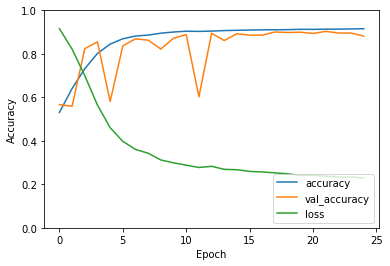

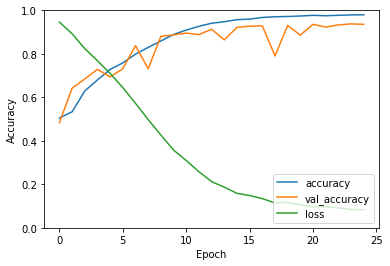

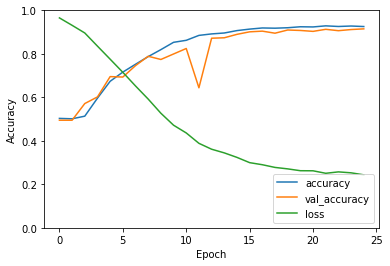

In [5]:
plt_count = 1
for assay, name in zip([pd.concat(dfs[0:5]), pd.concat(dfs[5:9]), pd.concat(dfs[9:17])],
                       ["ke1", "ke2", "ke3"]):

    assay["label"] = assay.sum(axis=1)

    assay = assay[["label"]]

    fingerprints = list()
    bad_smiles = []

    def get_fingerprint(row):
        try:
            sm = smiles.loc[row.name]
            mol = Chem.MolFromSmiles(sm.smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2) #, nBits=1024) # TODO: can replace morgan with other fingerprint!
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints.append(arr)
        except Exception as e:
            # print(e)
            print("Bad smiles string for", row.name)
            bad_smiles.append(row.name)

    assay.apply(lambda x: get_fingerprint(x), axis=1)

    print("ok:", len(fingerprints))
    print("bad:", bad_smiles)
    print("bad count:", len(bad_smiles))

    assay.drop(bad_smiles, inplace=True)

    inputs = np.array(fingerprints)
    X = inputs.reshape(-1, 2048)
    y = assay.values

    oversample = imblearn.over_sampling.SMOTE()
    X, y = oversample.fit_resample(X, y)

    X = X.reshape(-1, 2048, 1)
    y = y.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(Conv1D(32, 16, activation='relu', input_shape=(2048, 1)))
    model.add(MaxPool1D())
    model.add(Conv1D(64, 32, activation='relu'))
    model.add(MaxPool1D())
    model.add(Conv1D(128, 16, activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=2048, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1024, activation='relu'))
    model.add(Dense(units=y.shape[1], activation='sigmoid'))

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'],
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

    class_weight = {0: 1.,
                    1: float(len(X_train) / sum(y_train))}

    history = model.fit(
        X_train, y_train, epochs=25, verbose=1, validation_data=(X_test, y_test), class_weight=class_weight,
    )

    plt.figure(plt_count)
    plt_count += 1
    
    plt.plot(history.history["accuracy"], label='accuracy')
    plt.plot(history.history["val_accuracy"], label='val_accuracy')
    plt.plot(history.history["loss"], label='loss')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1])
    plt.legend(loc='lower right')

    vacc = max(history.history["val_accuracy"])
    acc = max(history.history["accuracy"])

    print(acc, vacc)

    model.save(f"models/skec/nn_{name}.h5")
    plt.savefig(f"models/skec/train_{name}_{acc}_{vacc}.png")
    print("model saved", name)
